In [1]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots
sns.set()

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

%matplotlib inline

In [1]:
!pip install tqdm --force

  Using cached https://files.pythonhosted.org/packages/76/4c/103a4d3415dafc1ddfe6a6624333971756e2d3dd8c6dc0f520152855f040/tqdm-4.30.0-py2.py3-none-any.whl
distributed 1.21.8 requires msgpack, which is not installed.
pgadmin4 3.5 has requirement Flask==0.12.4, but you'll have flask 1.0.2 which is incompatible.
pgadmin4 3.5 has requirement Flask-Migrate==2.1.1, but you'll have flask-migrate 2.3.1 which is incompatible.
pgadmin4 3.5 has requirement pbr==3.1.1, but you'll have pbr 5.1.1 which is incompatible.
pgadmin4 3.5 has requirement pytz==2018.3, but you'll have pytz 2018.9 which is incompatible.
awscli 1.16.69 has requirement botocore==1.12.59, but you'll have botocore 1.12.62 which is incompatible.
chatterbot 0.8.7 has requirement python-dateutil<2.7,>=2.6, but you'll have python-dateutil 2.7.5 which is incompatible.
chalice 1.6.1 has requirement click<7.0,>=6.6, but you'll have click 7.0 which is incompatible.
  Found existing installation: tqdm 4.30.0
    Uninstalling tqdm-4.30.0:

In [3]:
!pwd

/home/rmg/STORAGE/tests_courses/courses/mlcourse.ai/time_series


In [4]:
ads = pd.read_csv(
    '../../data/ads.csv', index_col=['Time'], parse_dates=['Time']
).sort_index()
currency = pd.read_csv(
    '../../data/currency.csv', index_col=['Time'], parse_dates=['Time']
).sort_index()

In [5]:
def display_horizontal(*args, percent_sep=5):
    html_str=''
    for table in args:
        df = table if isinstance(table, pd.DataFrame) else  pd.DataFrame(table)
        html_str+=df.to_html()
    display_html(
        html_str.replace(
            'table','table style="display:inline;padding-right:{}%"'.format(percent_sep)
        ), 
        raw=True)

In [6]:
from IPython.display import display_html, display

display(
    display_horizontal(ads.head(3), ads.tail(3))
)
display(
    display_horizontal(currency.head(3), currency.tail(3))
)

,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
,Ads
Time,
2017-09-21 21:00:00,103080
2017-09-21 22:00:00,95155
2017-09-21 23:00:00,80285


None

,GEMS_GEMS_SPENT
Time,
2017-05-01,1199436
2017-05-02,1045515
2017-05-03,586111
,GEMS_GEMS_SPENT
Time,
2018-02-22,2175548
2018-02-23,2122606
2018-02-24,1756394


None

In [7]:
display(ads.dtypes, 
        ads.columns, 
        ads.Ads.isnull().sum(), 
        type(ads)
)
display("/"*20)
display("/"*20)
display(currency.dtypes, 
        currency.columns, 
        currency.GEMS_GEMS_SPENT.isnull().sum(),
        type(currency)
)

Ads    int64
dtype: object

Index(['Ads'], dtype='object')

0

pandas.core.frame.DataFrame

'////////////////////'

'////////////////////'

GEMS_GEMS_SPENT    int64
dtype: object

Index(['GEMS_GEMS_SPENT'], dtype='object')

0

pandas.core.frame.DataFrame

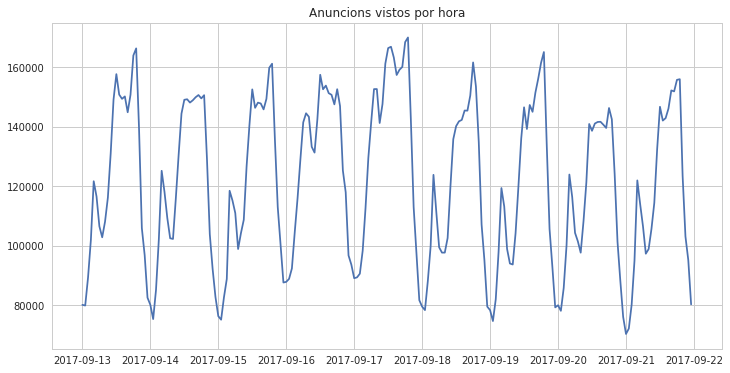

In [8]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.plot(ads.Ads)
plt.title('Anuncions vistos por hora')
plt.grid(True)
plt.show()

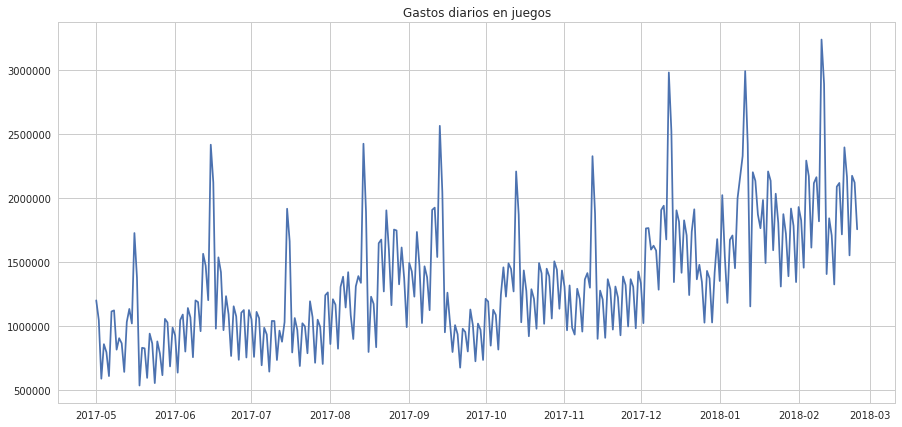

In [9]:
plt.figure(figsize=(15, 7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('Gastos diarios en juegos')
plt.grid(True)
plt.show()

### GRAFICANDO MEDIAS MOVILES

In [10]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

'Vamos a suavizar las 4 horas anteriores.'

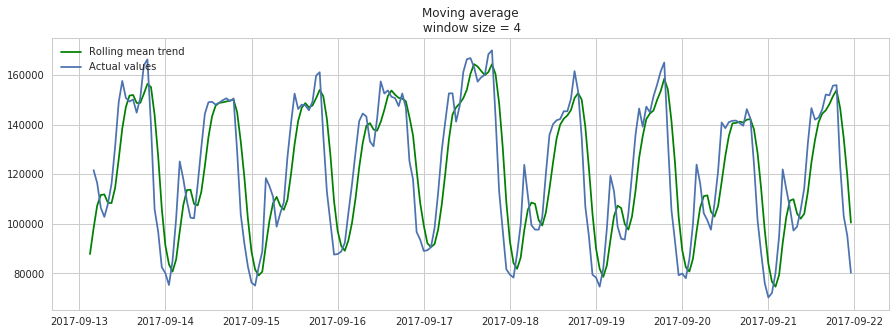

In [12]:
display('Vamos a suavizar las 4 horas anteriores.')
plotMovingAverage(ads, 4)

'Ahora las 12 horas anteriores'

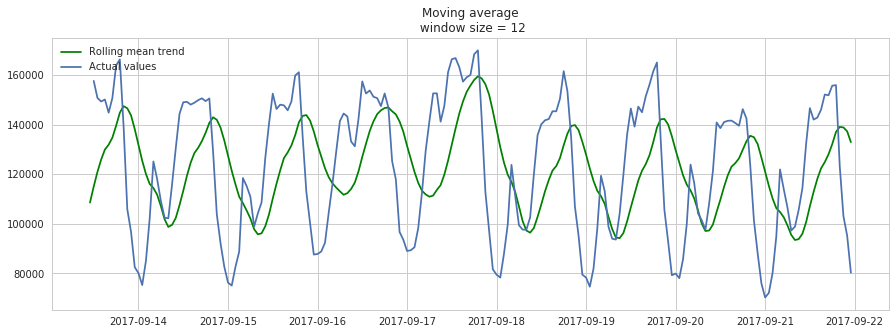

In [13]:
display('Ahora las 12 horas anteriores')
plotMovingAverage(ads, 12)

'Ahora con las 18 horas'

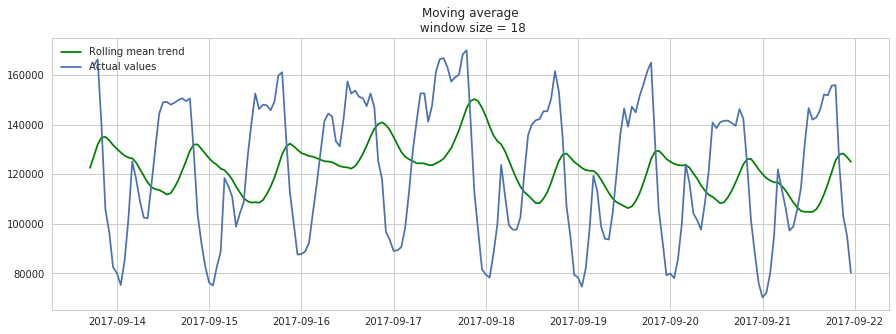

In [14]:
display('Ahora con las 18 horas')
plotMovingAverage(ads, 18)

'Ahora con las 24 horas anteriores, conseguimos la tendencia diaria.'

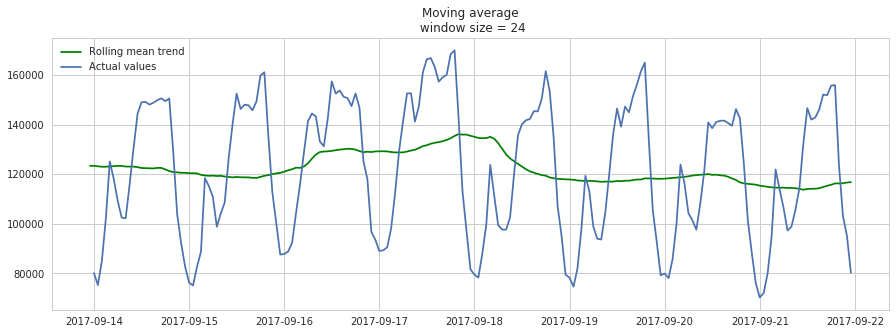

In [15]:
display('Ahora con las 24 horas anteriores, conseguimos la tendencia diaria.')
plotMovingAverage(ads, 24)

Cuando aplicamos el suavizado diario a los datos por hora, pudimos ver claramente la dinámica de los anuncios vistos. Durante los fines de semana, los valores son más altos (más tiempo para jugar los fines de semana), mientras que se ven menos anuncios los días de semana.

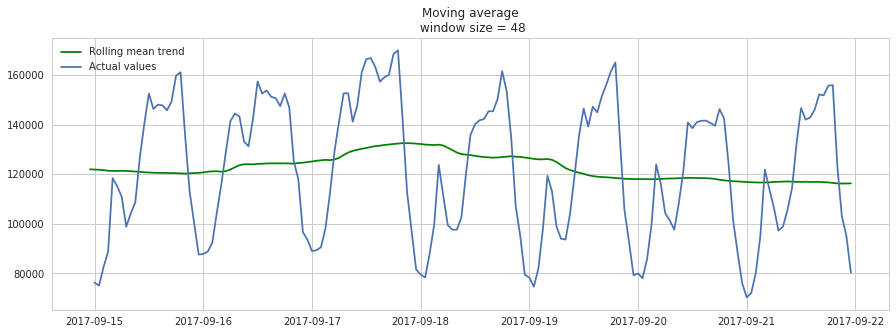

In [16]:
plotMovingAverage(ads, 48)

### También podemos trazar intervalos de confianza para nuestros valores suavizados.

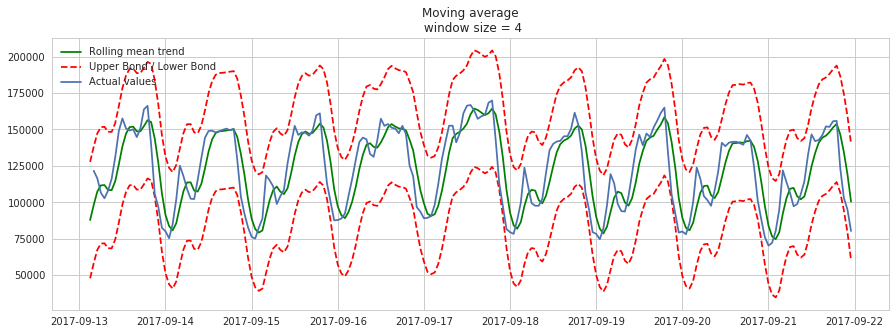

In [17]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

plotMovingAverage(ads, 4, plot_intervals=True)

Ahora, vamos a crear un sistema de detección de anomalías simple con la ayuda de la media móvil. Desafortunadamente, en este conjunto de datos en particular, todo es más o menos normal, por lo que intencionalmente haremos uno de los valores anormales en nuestra estructura de datos ads_anomaly.

In [18]:
ads_anomaly = ads.copy()
ads_anomaly.iloc[-20] = ads_anomaly.iloc[-20] * 0.2

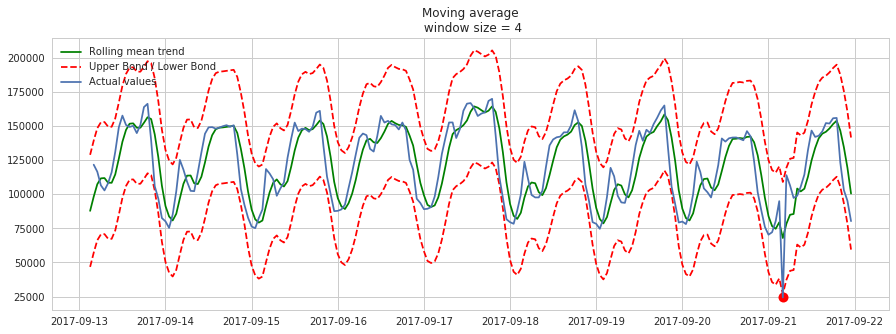

In [19]:
plotMovingAverage(ads_anomaly, 4, plot_intervals=True, plot_anomalies=True)

### ¿Qué pasa con la segunda serie?

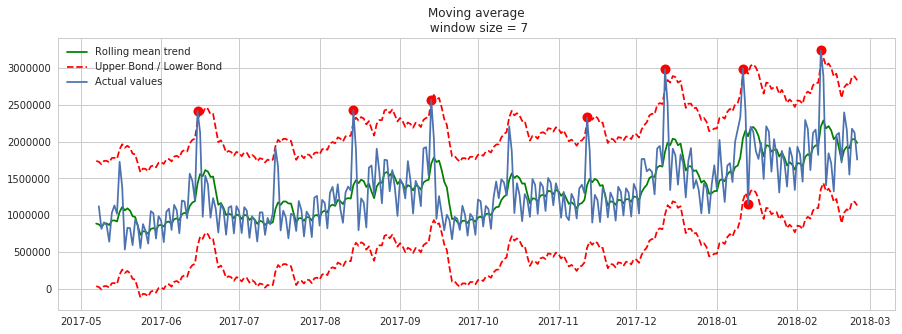

In [20]:
plotMovingAverage(currency, 7, plot_intervals=True, plot_anomalies=True)

¡Oh no, esto no fue tan genial! Aquí, podemos ver la desventaja de nuestro enfoque simple: no capturó la estacionalidad mensual en nuestros datos y marcó casi todos los picos de 30 días como anomalías. Si desea evitar los falsos positivos, es mejor considerar modelos más complejos.

### PROMEDIO PONDERADO

Es una simple modificación de la media móvil. Los pesos suman hasta 1 con pesos mayores asignados a observaciones más recientes.

In [21]:
def weighted_average(series, weights):
    # Calcular promedio ponderado en serie
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [22]:
weighted_average(ads, [0.6, 0.3, 0.1])

98423.0

In [23]:
display(weighted_average(ads, [0.4, 0.3, 0.2, 0.1]))
display(weighted_average(ads, [0.4, 0.4, 0.1, 0.1]))
display(weighted_average(ads, [0.5, 0.3, 0.1, 0.1]))
display(weighted_average(ads, [0.5, 0.2, 0.2, 0.1]))

107341.5

108134.0

110165.5

109373.0

### PROMEDIO DE LOS ULTIMOS N

In [24]:
def moving_average(series, n):
    # Calcular el promedio de las últimas n observaciones
    return np.average(series[-n:])

In [25]:
display(moving_average(ads, 3))

92840.0

In [26]:
display(moving_average(ads, 4))
display(moving_average(ads, 12))
display(moving_average(ads, 18))
display(moving_average(ads, 24))

100478.75

132903.33333333334

124990.83333333333

116805.0

### SUAVIZAMIENTO EXPONENCIAL

Ahora, veamos qué sucede si, en lugar de ponderar los últimos valores kk de la serie de tiempo, comenzamos a ponderar todas las observaciones disponibles mientras disminuimos exponencialmente los pesos a medida que retrocedemos en el tiempo. Existe una fórmula para el suavizado exponencial que nos ayudará con esto:

y^t = α⋅yt + (1−α)⋅y^t−1

Aquí, el valor del modelo es un promedio ponderado entre el valor verdadero actual y los valores del modelo anterior. El peso 'α' se llama factor de suavizado. Define qué tan rápido "olvidaremos" la última observación verdadera disponible. Cuanto más pequeño es 'α', más influencia tienen las observaciones previas y más suave es la serie.

La exponencialidad está oculta en la recursividad de la función: multiplicamos por (1 − α) (1 − α) cada vez, que ya contiene una multiplicación por (1 − α) (1 − α) de los valores del modelo anterior.

In [27]:
def exponential_smoothing(series, alpha):
    # series - serie de tiempo
    # alpha - parametro de suavizado

    result = [series[0]] # el primer valor coincide con el de la serie
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [28]:
def plotExponentialSmoothing(series, alphas):
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

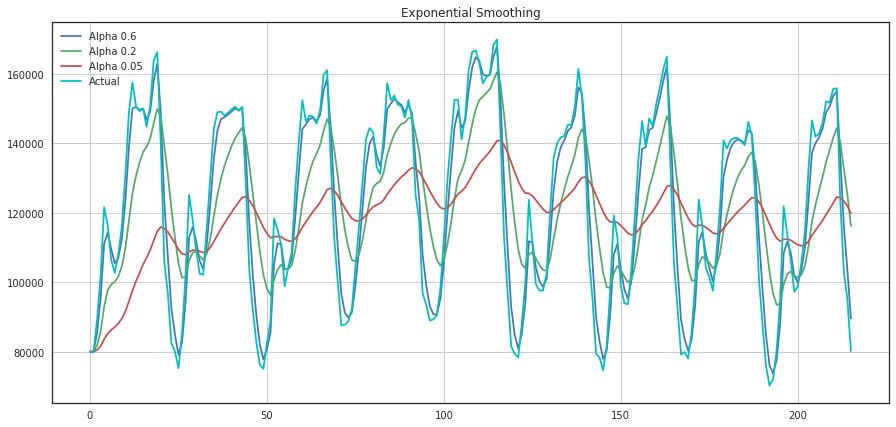

In [29]:
plotExponentialSmoothing(ads.Ads, [0.6, 0.2, 0.05])

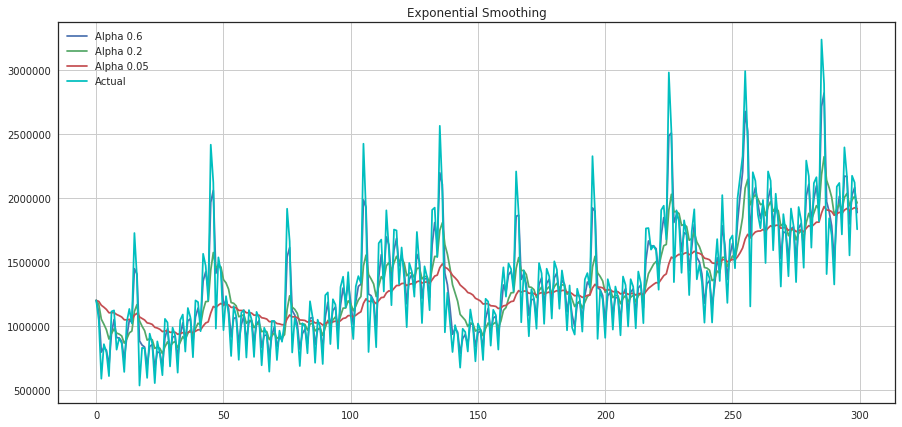

In [30]:
plotExponentialSmoothing(currency.GEMS_GEMS_SPENT, [0.6, 0.2, 0.05])

### DOBLE SUAVIZAMIENTO EXPONENCIAL

Hasta ahora, los métodos que hemos discutido han sido para una única predicción de puntos futuros (con un buen suavizado). Eso es genial, pero tampoco es suficiente. Extendamos el suavizado exponencial para poder predecir dos puntos futuros (por supuesto, también incluiremos más suavizado).

La descomposición de la serie nos ayudará a obtener dos componentes: intercepción (es decir, nivel) ℓ y pendiente (es decir, tendencia) b. Hemos aprendido a predecir la intercepción (o el valor esperado de la serie) con nuestros métodos anteriores; ahora, aplicaremos el mismo suavizado exponencial a la tendencia asumiendo que la dirección futura de los cambios de series de tiempo depende de los cambios ponderados anteriores. Como resultado, obtenemos el siguiente conjunto de funciones:

ℓx = αyx + (1 − α)(ℓx −1+bx − 1)
<br>
bx=β(ℓx − ℓx − 1)+(1 − β)bx − 1
<br>
y^x + 1 = ℓx + bx
T

El primero describe la intercepción, que, como antes, depende del valor actual de la serie. El segundo término ahora se divide en valores anteriores del nivel y de la tendencia. La segunda función describe la tendencia, que depende de los cambios de nivel en el paso actual y del valor anterior de la tendencia. En este caso, el coeficiente β es un peso para el alisamiento exponencial. La predicción final es la suma de los valores de modelo del intercepto y la tendencia.

In [31]:
def double_exponential_smoothing(series, alpha, beta):
    # alpha - parametro de suavizamiento de nivel
    # beta - parametro de suavizamirnto de tendencia

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series):
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

In [32]:
def plotDoubleExponentialSmoothing(series, alphas, betas):
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

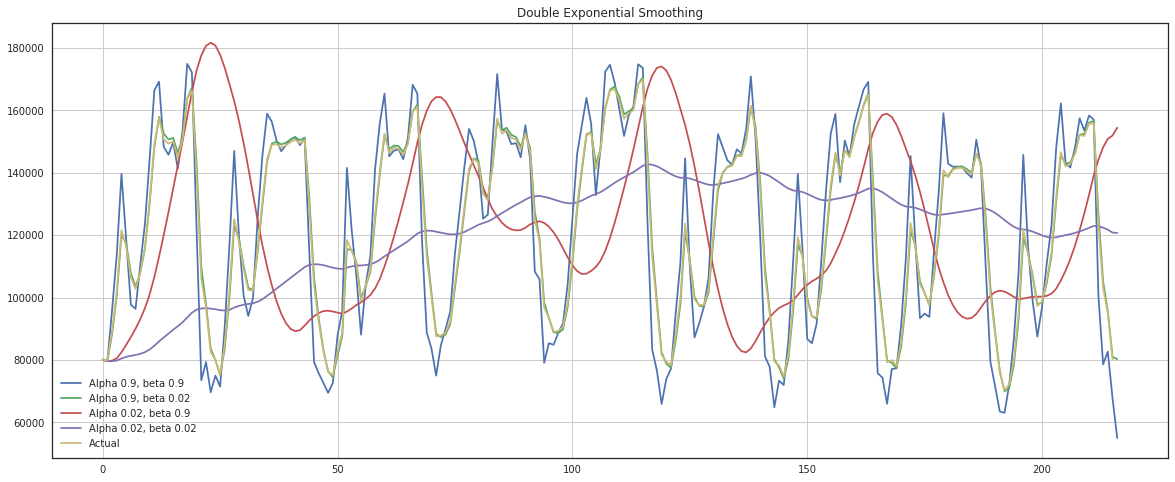

In [33]:
plotDoubleExponentialSmoothing(ads.Ads, alphas=[0.9, 0.02], betas=[0.9, 0.02])

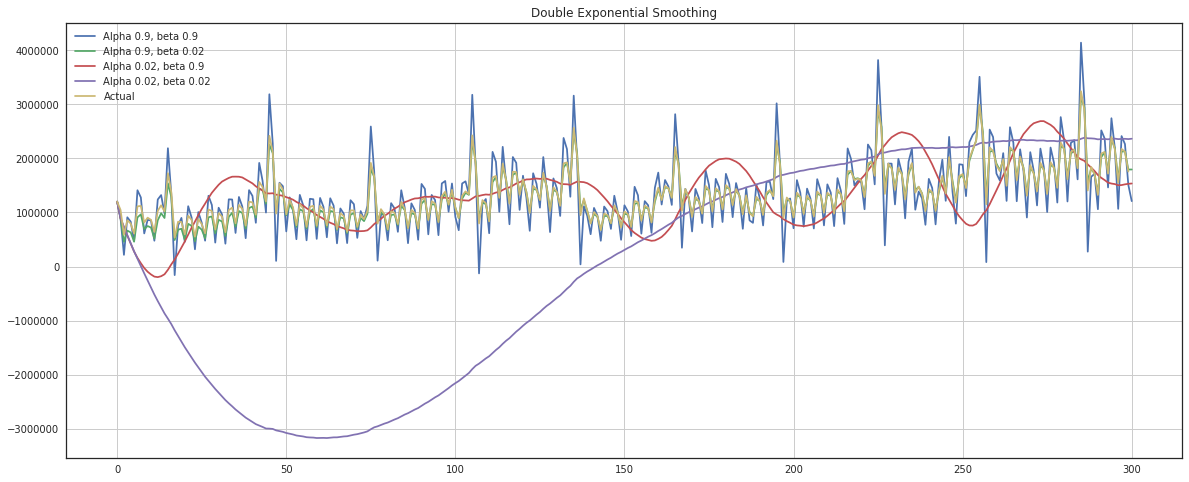

In [34]:
plotDoubleExponentialSmoothing(currency.GEMS_GEMS_SPENT, alphas=[0.9, 0.02], betas=[0.9, 0.02])

Ahora tenemos que ajustar dos parámetros: α y β. El primero es responsable del suavizado de la serie en torno a la tendencia, y el segundo del suavizado de la tendencia en sí. Cuanto mayores sean los valores, mayor será el peso de las observaciones más recientes y menor será el suavizado de la serie del modelo. Ciertas combinaciones de los parámetros pueden producir resultados extraños, especialmente si se configuran manualmente. Veremos cómo elegir parámetros automáticamente en un momento; Antes de eso, vamos a discutir el suavizado exponencial triple.

### TRIPLE SUAVIZADO EXPONENCIAL a.k.a. Holt-Winters

Hemos examinado el suavizado exponencial y el doble suavizado exponencial. Esta vez, vamos a hacer un triple alisamiento exponencial. Como podría haber adivinado, la idea es agregar un tercer componente: la estacionalidad. Esto significa que no deberíamos usar este método si no se espera que nuestra serie de tiempo tenga estacionalidad. Los componentes estacionales en el modelo explicarán las variaciones repetidas en torno a la intersección y la tendencia, y se especificarán por la duración de la temporada, es decir, por el período después del cual se repiten las variaciones. Para cada observación en la temporada, hay un componente separado; por ejemplo, si la duración de la temporada es de 7 días (una estacionalidad semanal), tendremos 7 componentes estacionales, uno para cada día de la semana. Con esto, vamos a escribir un nuevo sistema de ecuaciones:

ℓx = α(yx − sx − L) + (1 − α)(ℓx − 1 + bx − 1)
<br>
bx = β(ℓx − ℓx−1) + (1 − β)bx−1
<br>
sx = γ(yx − ℓx)+(1 − γ)sx− L
<br>
y^x + m = ℓx+ mbx + sx −L + 1+ (m−1)modL

La intersección ahora depende del valor actual de la serie menos cualquier componente estacional correspondiente. La tendencia permanece sin cambios, y el componente estacional depende del valor actual de la serie menos la intersección y del valor anterior del componente. Tenga en cuenta que el componente se suaviza a través de todas las temporadas disponibles; por ejemplo, si tenemos un componente de lunes, entonces solo se promediará con otros lunes. Puede leer más sobre cómo funciona el promedio y cómo se realiza aquí la aproximación inicial de la tendencia y los componentes estacionales. Ahora que tenemos el componente estacional, podemos predecir no solo uno o dos pasos por delante, sino un futuro arbitrario en mm, lo que es muy alentador. A continuación se muestra el código para un modelo de suavizado exponencial triple, que también se conoce por los apellidos de sus creadores, Charles Holt y su estudiante Peter Winters. Además, el método Brutlag se incluyó en el modelo para producir intervalos de confianza:

y^maxx = ℓx−1 + bx−1 + sx − T+m⋅dt−T
<br>
y^minx = ℓx−1 + bx−1 + sx−T−m⋅dt−T
<br>
dt = γ∣yt − y^t∣ + (1 − γ)dt−T

donde 'T' es la duración de la temporada, 'd' es la desviación predicha. 

In [35]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

## VALIDACION CRUZADA PARA SERIES DE TIEMPO

Antes de comenzar a construir un modelo, veamos primero cómo estimar los parámetros del modelo automáticamente. No hay nada inusual aquí; como siempre, tenemos que elegir una función de pérdida adecuada para la tarea que nos dirá qué tan cerca se aproxima el modelo a los datos. Luego, utilizando la validación cruzada, evaluaremos la función de pérdida elegida para los parámetros del modelo dados, calcularemos el gradiente, ajustaremos los parámetros del modelo, y así sucesivamente, descenderemos al mínimo global. Es posible que se pregunte cómo realizar una validación cruzada para series de tiempo porque las series de tiempo tienen esta estructura temporal y no se pueden mezclar los valores aleatoriamente en un pliegue mientras se conserva esta estructura. Con la aleatorización, se perderán todas las dependencias temporales entre las observaciones. Es por esto que tendremos que usar un enfoque más complicado para optimizar los parámetros del modelo. No sé si hay un nombre oficial para esto, pero en CrossValidated, donde se pueden encontrar todas las respuestas, excepto la Respuesta a la última cuestión de la vida, el universo y todo, el nombre propuesto para este método es "validación cruzada sobre una base de rodadura ". La idea es bastante simple: entrenamos nuestro modelo en un pequeño segmento de la serie de tiempo desde el principio hasta algunos tt, hacemos predicciones para los próximos pasos t + nt + n, y calculamos un error. Luego, expandimos nuestra muestra de entrenamiento a t + nt + n valor, hacemos predicciones desde t + nt + n hasta t + 2 ∗ nt + 2 ∗ n, y continuamos moviendo nuestro segmento de prueba de la serie de tiempo hasta que alcancemos el último observación. Como resultado, tenemos tantos pliegues como nn cabrá entre la muestra de entrenamiento inicial y la última observación.

Ahora, sabiendo cómo configurar la validación cruzada, podemos encontrar los parámetros óptimos para el modelo de Holt-Winters. Recuerde que tenemos estacionalidad diaria en los anuncios, de ahí el parámetro slen = 24.

In [36]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

En el modelo de Holt-Winters, así como en los otros modelos de suavizado exponencial, existe una restricción sobre el tamaño de los parámetros de suavizado, cada uno de ellos de 0 a 1. Por lo tanto, para minimizar nuestra función de pérdida, Debe elegir un algoritmo que admita restricciones en los parámetros del modelo. En nuestro caso, usaremos el gradiente de conjugado de Newton truncado.

In [37]:
%%time
data = ads.Ads[:-20] # # Dejaré algunos datos para probar

# Inicializo los parámetros del modelo alfa, beta y gamma.
x = [0, 0, 0] 

# # Minimizando la función de pérdida
opt = minimize(
    timeseriesCVscore, x0=x, 
    args=(data, mean_squared_log_error), 
    method="TNC", bounds=((0, 1), (0, 1), (0, 1))
)

# Tomando valores óptimos.
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# y entrena el modelo con ellos, pronosticando para las próximas 50 horas.
model = HoltWinters(data, slen = 24, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)
model.triple_exponential_smoothing()

0.11652680227350454 0.002677697431105852 0.05820973606789237
CPU times: user 1.34 s, sys: 0 ns, total: 1.34 s
Wall time: 1.34 s


### Graficando

In [38]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

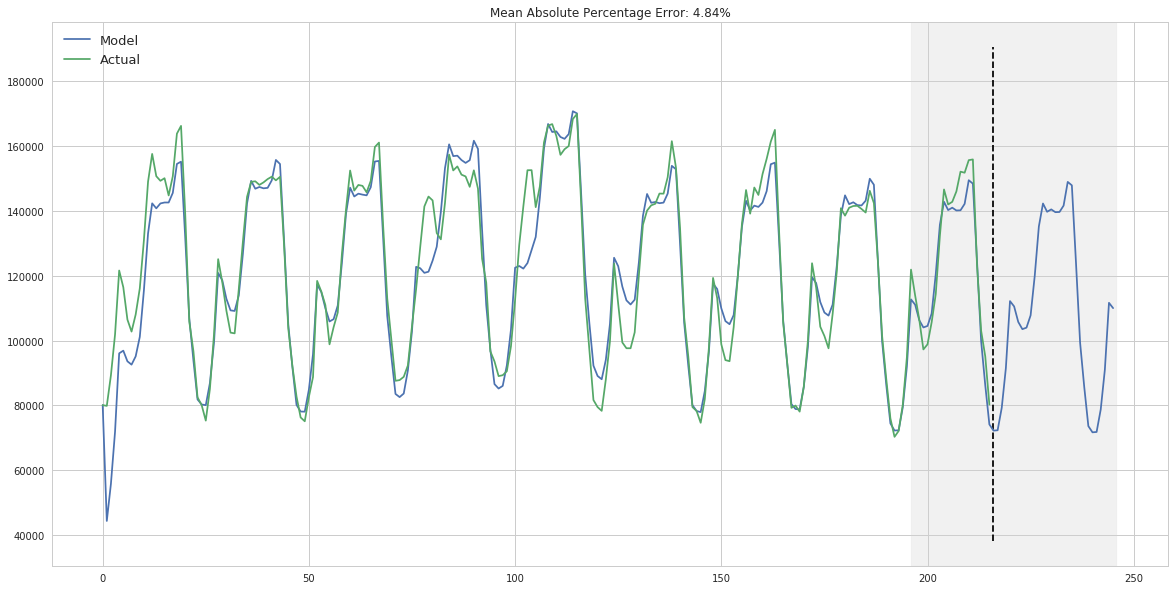

In [39]:
plotHoltWinters(ads.Ads)

In [40]:
ads.Ads.values.shape, len(model.result)

((216,), 246)

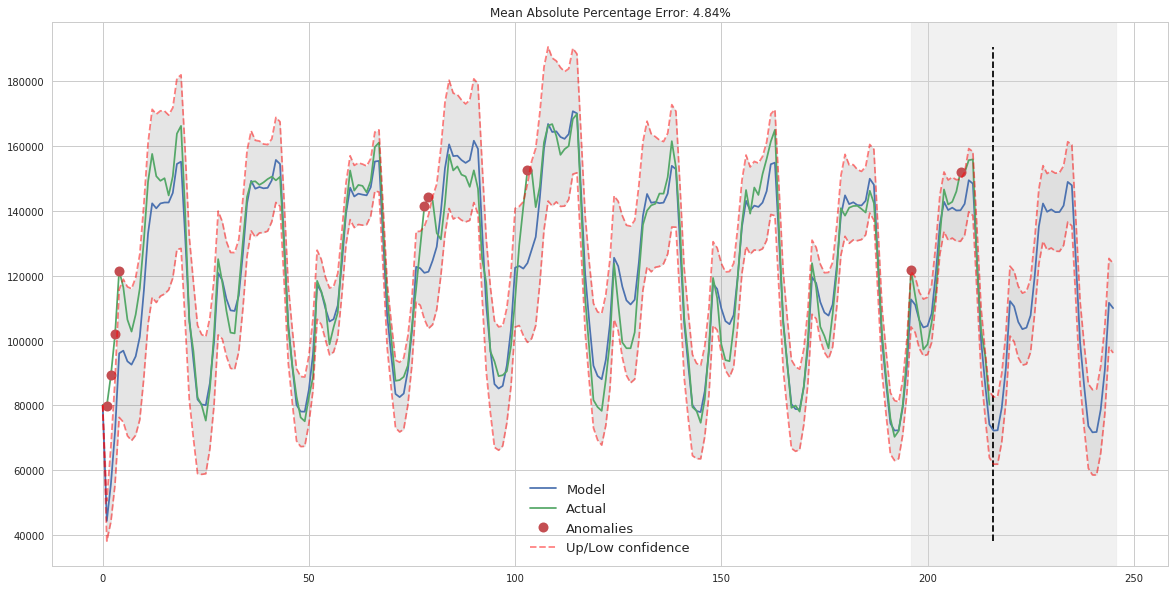

In [41]:
plotHoltWinters(ads.Ads, plot_intervals=True, plot_anomalies=True)

A juzgar por las parcelas, nuestro modelo pudo aproximar con éxito la serie de tiempo inicial, capturando la estacionalidad diaria, la tendencia general a la baja e incluso algunas anomalías. Si observa las desviaciones del modelo, puede ver claramente que el modelo reacciona bastante bruscamente a los cambios en la estructura de la serie, pero luego devuelve rápidamente la desviación a los valores normales, esencialmente "olvidando" el pasado. Esta característica del modelo nos permite construir rápidamente sistemas de detección de anomalías, incluso para datos de series ruidosas, sin gastar demasiado tiempo y dinero en la preparación de los datos y la capacitación del modelo.

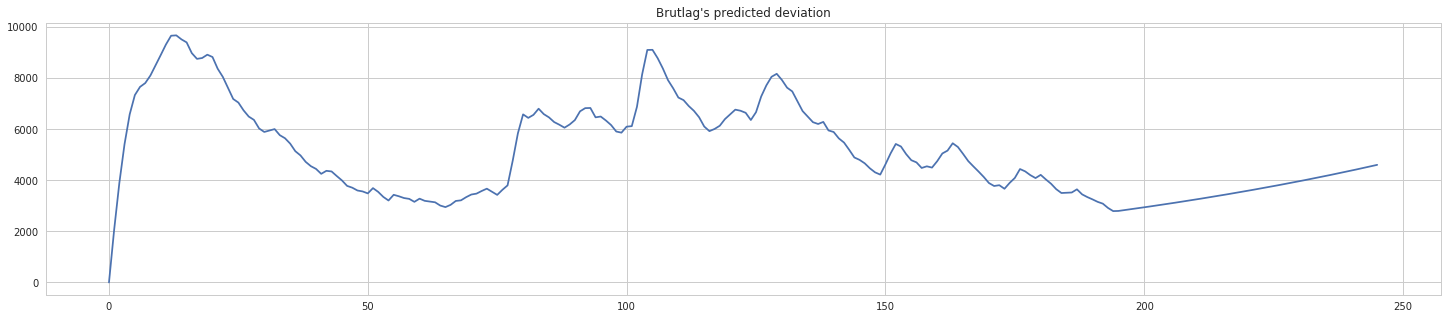

In [42]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

### Aplicaremos el mismo algoritmo para la segunda serie que, como puede recordar, tiene tendencia y una estacionalidad de 30 días.

In [43]:
%%time
data = currency.GEMS_GEMS_SPENT[:-50] 
slen = 30 # 30-day seasonality

x = [0, 0, 0] 

opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_absolute_percentage_error, slen), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

model = HoltWinters(data, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 100, scaling_factor = 3)
model.triple_exponential_smoothing()

0.012841445048055122 0.04883371471892228 0.00943678056045777
CPU times: user 2.11 s, sys: 6.04 ms, total: 2.11 s
Wall time: 2.07 s


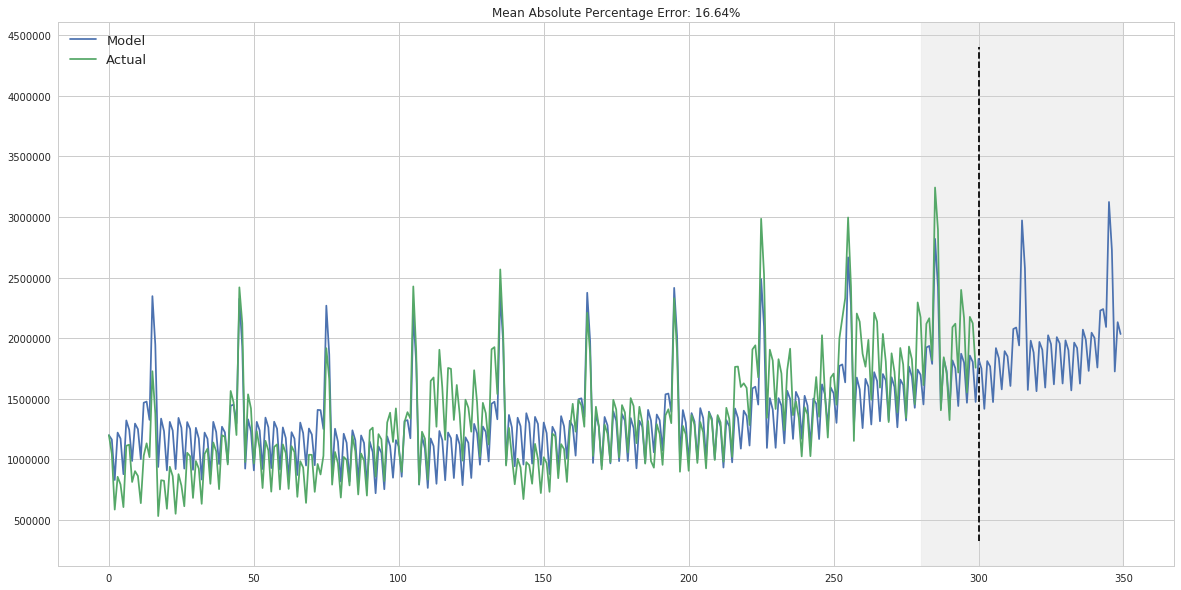

In [44]:
plotHoltWinters(currency.GEMS_GEMS_SPENT)

Se ve bien! El modelo captó tanto la tendencia al alza como los picos estacionales y se ajusta muy bien a los datos.

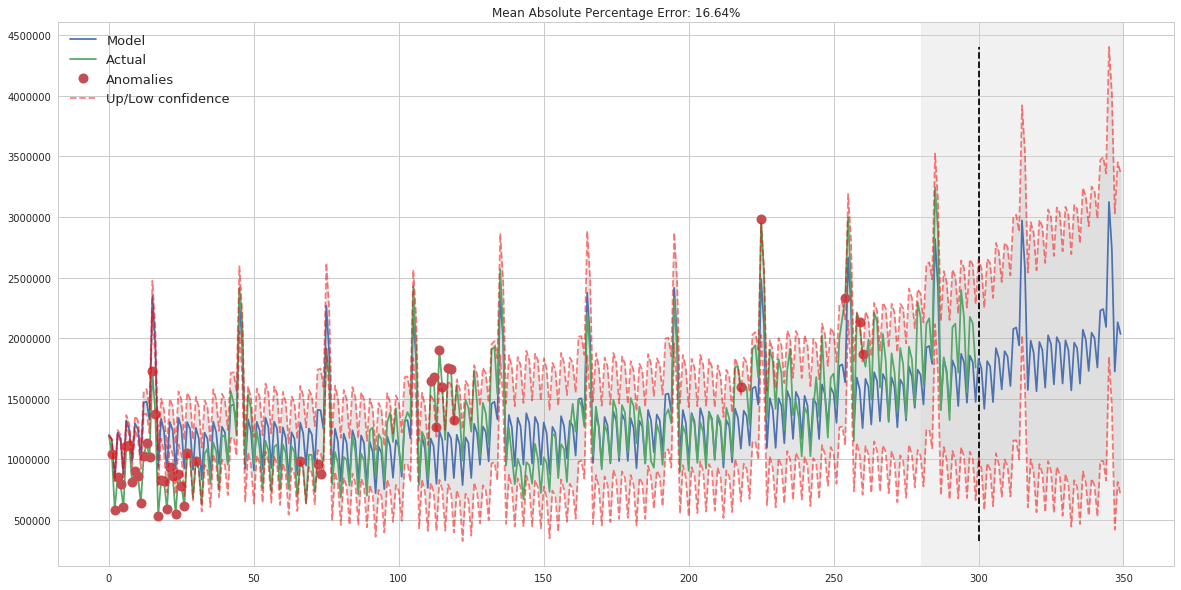

In [45]:
plotHoltWinters(currency.GEMS_GEMS_SPENT, plot_intervals=True, plot_anomalies=True)

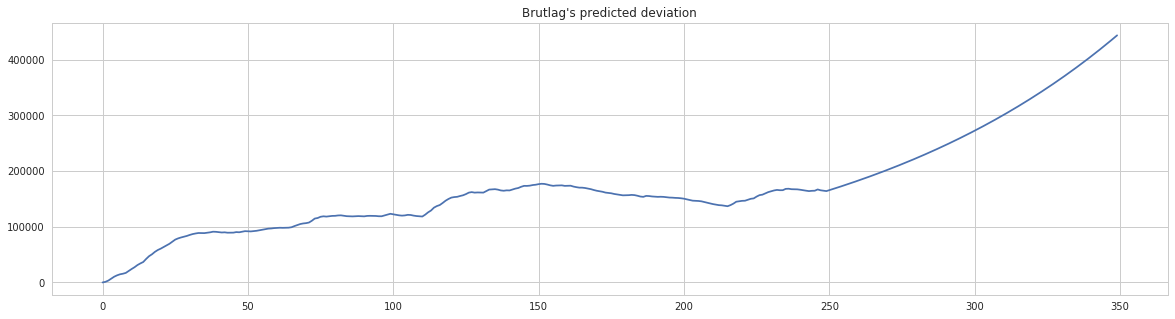

In [46]:
plt.figure(figsize=(20, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

### ENFOQUE ECONOMETRICO

Antes de comenzar a modelar, debemos mencionar una propiedad tan importante de las series de tiempo: la estacionalidad.

Si un proceso es estacionario, eso significa que no cambia sus propiedades estadísticas a lo largo del tiempo, es decir, su media y varianza. (La constancia de la varianza se denomina homoscedasticidad) La función de covarianza no depende del tiempo; Sólo debería depender de la distancia entre las observaciones. Puedes ver esto visualmente en las imágenes en el post de Sean Abu: El gráfico rojo a continuación no es estacionario porque la media aumenta con el tiempo.

<img src="https://habrastorage.org/files/20c/9d8/a63/20c9d8a633ec436f91dccd4aedcc6940.png" alt="no hay" height="300" width="500">

Tuvimos mala suerte con la varianza y observamos la variación de los valores a lo largo del tiempo.

<img src="https://habrastorage.org/files/b88/eec/a67/b88eeca676d642449cab135273fd5a95.png" alt="no hay" height="300" width="500">

Finalmente, la covarianza del término i th y el término (i + m) th no deben ser una función del tiempo. En el siguiente gráfico, notará que la propagación se acerca a medida que aumenta el tiempo. Por lo tanto, la covarianza no es constante con el tiempo en el gráfico correcto.

<img src="https://habrastorage.org/files/2f6/1ee/cb2/2f61eecb20714352840748b826e38680.png" alt="no hay" height="300" width="500">

Entonces, ¿por qué es tan importante la estacionariedad? Debido a que es fácil hacer predicciones en una serie estacionaria ya que podemos asumir que las propiedades estadísticas futuras no serán diferentes de las observadas actualmente. La mayoría de los modelos de series de tiempo, de una u otra forma, intentan predecir esas propiedades (media o varianza, por ejemplo). Las predicciones de Furture serían erróneas si las series originales no fueran estacionarias. Desafortunadamente, la mayoría de las series de tiempo que vemos fuera de los libros de texto no son estacionarias, pero podemos (y debemos) cambiar esto. Entonces, para combatir la no estacionariedad, tenemos que conocer a nuestro enemigo, por así decirlo. Veamos cómo podemos detectarlo. Miraremos el ruido blanco y las caminatas al azar para aprender cómo ir de una a otra de forma gratuita. Carta de ruido blanco:

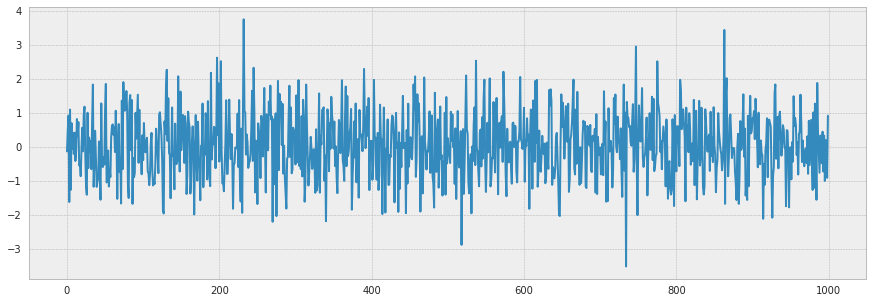

In [47]:
white_noise = np.random.normal(size=1000)
with plt.style.context('bmh'):  
    plt.figure(figsize=(15, 5))
    plt.plot(white_noise)

El proceso generado por la distribución normal estándar es estacionario y oscila alrededor de 0 con una desviación de 1. Ahora, a partir de este proceso, generaremos uno nuevo donde cada valor subsiguiente dependerá del anterior:  xt = ρxt−1 + et

Aquí está el código para hacer las parcelas.

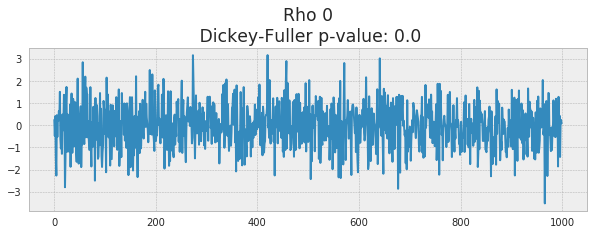

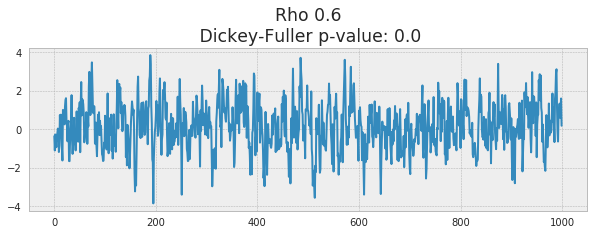

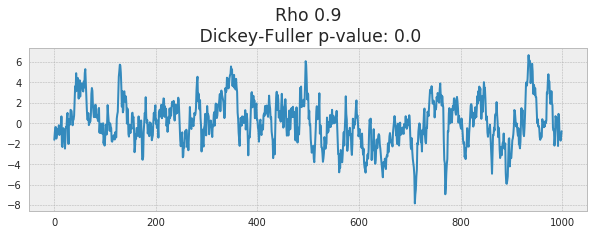

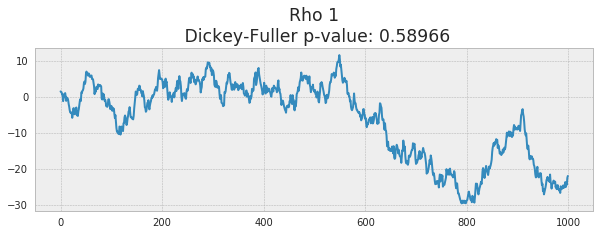

In [45]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]
    
    with plt.style.context('bmh'):
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title(
            "Rho {}\n Dickey-Fuller p-value: {}".format(
                rho, 
                round(sm.tsa.stattools.adfuller(x)[1], 5))
        )
    
for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)

En la primera parcela, puedes ver el mismo ruido blanco estacionario que antes. En la segunda parcela con ρρ aumentada a 0,6, aparecieron ciclos más amplios, pero aún parece estacionario en general. La tercera trama se desvía aún más de la media 0, pero todavía oscila sobre la media. Finalmente, con ρ = 1, tenemos un proceso de recorrido aleatorio, es decir, una serie de tiempo no estacionaria.

## Deshacerse de la no estacionariedad y construir SARIMA.

Construyamos un modelo ARIMA recorriendo todos los círculos de las etapas del proceso para hacer una serie estacionaria.

In [48]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    # lags - Numero de retrasos a incluir para el calculo de ACF / PACF 
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
      
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

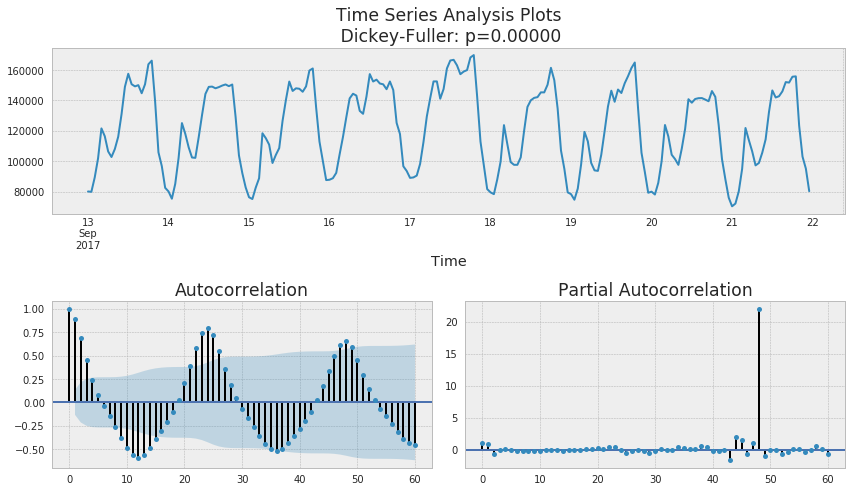

In [49]:
tsplot(ads.Ads, lags=60)

Sorprendentemente, las series iniciales son estacionarias; La prueba de Dickey-Fuller rechazó la hipótesis nula de que una raíz unitaria está presente. En realidad, podemos ver esto en la trama misma: no tenemos una tendencia visible, por lo que la media es constante y la varianza es bastante estable. Lo único que queda es la estacionalidad, con la que tenemos que lidiar antes de modelar. Para hacerlo, tomemos la "diferencia estacional", que significa una simple resta de la serie de sí misma con un retraso que es igual al período estacional.

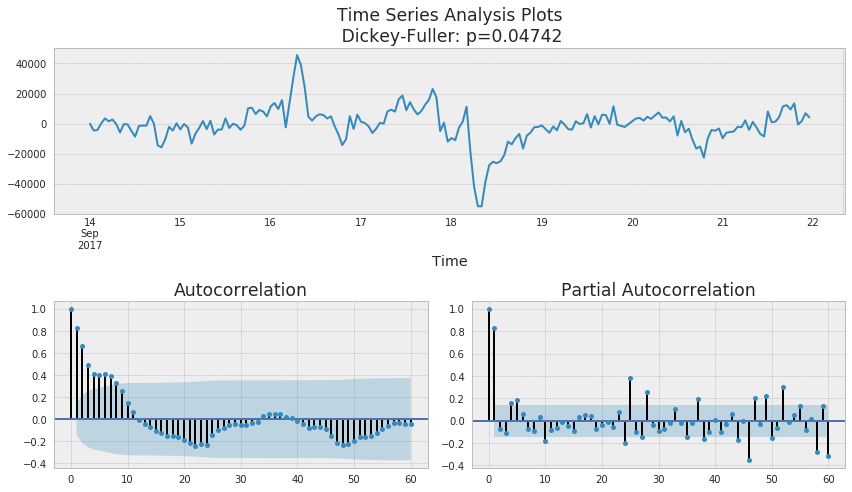

In [50]:
ads_diff = ads.Ads - ads.Ads.shift(24)
tsplot(ads_diff[24:], lags=60)

Ahora está mucho mejor con la estacionalidad visible desaparecida. Sin embargo, la función de autocorrelación todavía tiene demasiados retrasos significativos. Para eliminarlos, tomaremos las primeras diferencias, restando la serie de sí misma con el retraso 1.

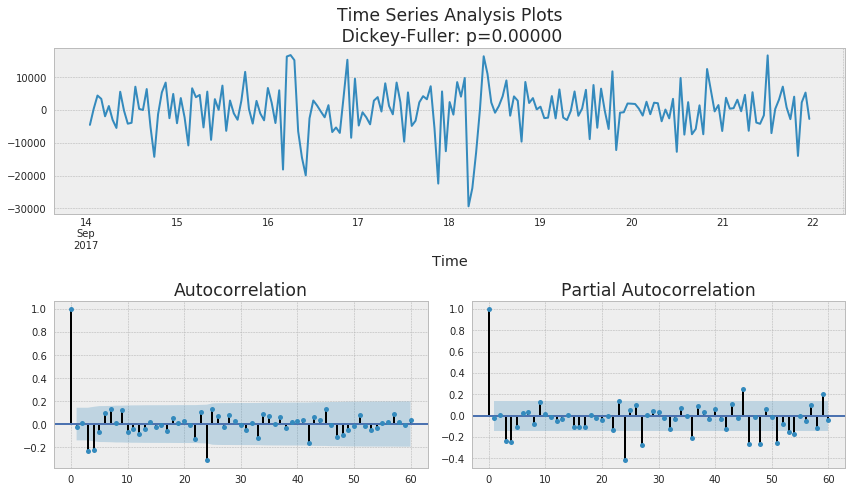

In [51]:
ads_diff = ads_diff - ads_diff.shift(1)
tsplot(ads_diff[24+1:], lags=60)

¡Perfecto! Nuestra serie ahora parece algo indescriptible, oscilando alrededor de cero. La prueba de Dickey-Fuller indica que es estacionaria, y el número de picos significativos en ACF ha disminuido. ¡Finalmente podemos empezar a modelar!

## Curso intensivo de la familia ARIMA

Explicaremos este modelo construyendo letra por letra. SARIMA (p, d, q) (P, D, Q, s) SARIMA (p, d, q) (P, D, Q, s), modelo de media móvil de regresión automática estacional:

AR (p) - modelo de autorregresión, es decir, regresión de la serie de tiempo sobre sí misma. El supuesto básico es que los valores de la serie actual dependen de sus valores anteriores con algún retraso (o varios retrasos). El retraso máximo en el modelo se conoce como p. Para determinar los pp iniciales, debe mirar el gráfico PACF y encontrar el mayor retraso significativo, después de lo cual la mayoría de los demás retrasos se vuelven insignificantes.

MA (q) - modelo de media móvil. Sin entrar en demasiados detalles, esto modela el error de la serie de tiempo, de nuevo con la suposición de que el error actual depende de la anterior con un cierto retraso, que se conoce como q. El valor inicial se puede encontrar en el gráfico ACF con la misma lógica que antes.

Combinemos nuestras primeras 4 letras

AR(p) + MA(q) = ARMA(p,q)

¡Lo que tenemos aquí es el modelo de media móvil autoregresivo! Si la serie es estacionaria, puede aproximarse con estas 4 letras. Continuemos.

I (d) - orden de integración. Esto es simplemente la cantidad de diferencias no estacionales necesarias para que la serie sea estacionaria. En nuestro caso, es solo 1 porque usamos las primeras diferencias.

Agregar esta letra a los cuatro nos da el modelo ARIMAARIMA que puede manejar datos no estacionarios con la ayuda de diferencias no estacionales. Genial, una letra más para iniciar!


S (s) : esto es responsable de la estacionalidad y es igual a la duración del período de temporada de la serie

### With this, we have three parameters: (P,D,Q)

P: orden de autorregresión para el componente estacional del modelo, que se puede derivar de PACF. Pero hay que mirar la cantidad de retrasos significativos, que son los múltiplos de la duración del período de la temporada. Por ejemplo, si el período es igual a 24 y vemos que los desfases 24 y 48 son significativos en el PACF, eso significa que el P inicial debería ser 2.

Q - similar logic using the ACF plot instead.

D - orden de integración estacional. Esto puede ser igual a 1 o 0, dependiendo de si las diferencias estacionales se aplicaron o no.

Ahora que sabemos cómo configurar los parámetros iniciales, echemos un vistazo a la gráfica final una vez más y establezcamos los parámetros:

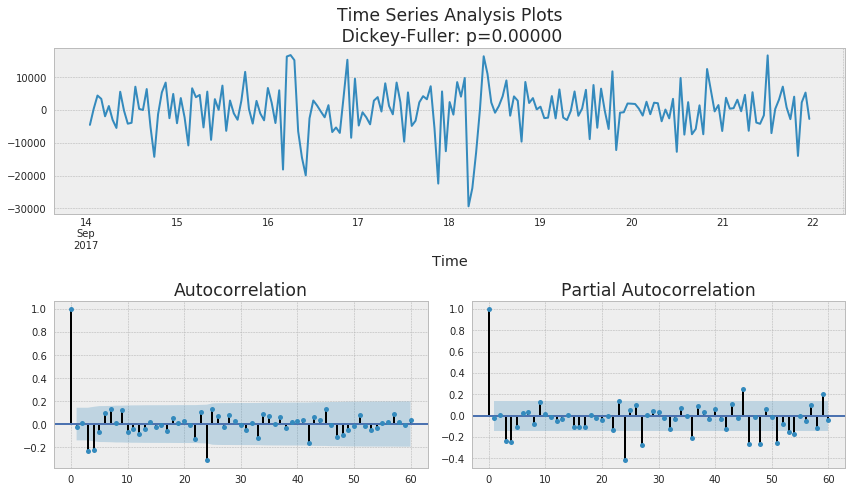

In [50]:
tsplot(ads_diff[24+1:], lags=60)

- p es probablemente 4 ya que es el último retraso significativo en el PACF, después del cual, la mayoría de los otros no son significativos.
- d es igual a 1 porque teníamos primeras diferencias
- q debería estar en algún lugar alrededor de 4, como se ve en la ACF
- P podría ser 2, ya que los retrasos 24 y 48 son algo significativos en el PACF
- D de nuevo es igual a 1 porque realizamos diferenciación estacional
- Q es probablemente 1. El retraso 24-en ACF es significativo, mientras que el 48-no es.

Probemos varios modelos y veamos cuál es mejor

In [51]:
# setting initial values and some bounds for them
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [52]:
tqdm_notebook(parameters_list)

0/|/  0%|| 0/36 [00:00<?, ?it/s]

In [53]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

24

In [54]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

CPU times: user 1min 58s, sys: 311 ms, total: 1min 59s
Wall time: 1min 1s


In [55]:
result_table

,parameters,aic
0,"(2, 3, 1, 1)",3888.642174
1,"(3, 2, 1, 1)",3888.763568
2,"(4, 2, 1, 1)",3890.279740
3,"(3, 3, 1, 1)",3890.513196
4,"(2, 4, 1, 1)",3892.302849
5,"(4, 3, 1, 1)",3892.322796
6,"(2, 2, 1, 1)",3894.798147
7,"(2, 3, 0, 1)",3897.170902
8,"(3, 2, 0, 1)",3897.815032
9,"(4, 2, 0, 1)",3899.073591


In [56]:
p, q, P, Q = result_table.parameters[0]

In [57]:
best_model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                Ads   No. Observations:                  216
Model:             SARIMAX(2, 1, 3)x(1, 1, 1, 24)   Log Likelihood               -1936.321
Date:                            Mon, 07 Jan 2019   AIC                           3888.642
Time:                                    09:53:24   BIC                           3914.660
Sample:                                09-13-2017   HQIC                          3899.181
                                     - 09-21-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7913      0.270      2.928      0.003       0.262       1.321
ar.L2         -0.5503      0.306   

In [58]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

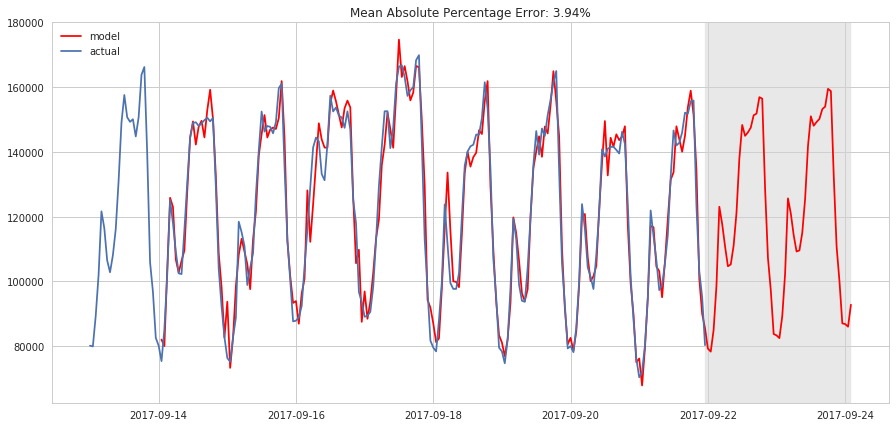

In [59]:
plotSARIMA(ads, best_model, 50)

Al final, tenemos predicciones muy adecuadas. Nuestro modelo estaba equivocado en un 4,01% en promedio, lo cual es muy, muy bueno. Sin embargo, los costos generales de preparar datos, hacer que la serie sea estacionaria y seleccionar los parámetros pueden no valer la pena.